# Build Data for the Map

Check and merge datasets from:
    cordis
    creative
    esif
    fts
    erasmus
    nhs
    nweurope
    life

In [2]:
%matplotlib inline

from functools import reduce
import glob
import json
import os

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 50)

## Define Validity Checks

In [3]:
ukpostcodes = pd.read_csv('../postcodes/input/ukpostcodes.csv.gz')
ukpostcodes.shape

(1762397, 4)

In [4]:
def validate_postcodes(df):
    assert 'postcode' in df.columns
    assert (~df['postcode'].isin(ukpostcodes.postcode)).sum() == 0
    
def validate_date_range(df):
    assert 'start_date' in df.columns
    assert 'end_date' in df.columns
    assert df['start_date'].dtype == 'datetime64[ns]'
    assert df['end_date'].dtype == 'datetime64[ns]'
    assert (df['start_date'] > df['end_date']).sum() == 0

## Load Cleaned Data

### CORDIS

In [5]:
fp7_organizations = pd.read_pickle('../cordis/output/fp7_organizations.pkl.gz')
validate_postcodes(fp7_organizations)
fp7_organizations.head()

project_rcn  organization_id         role                          name  \
0        85234        999903840  participant  The University of Manchester   
1        85235        999974165  participant         University of Glasgow   
2        85236        999975426  participant           University of Leeds   
3        85236        999990752  participant       Loughborough University   
4        85238        999840984  participant          Lancaster University   

   contribution_eur             organization_url  postcode  
0          346277.0  http://www.manchester.ac.uk   M13 9PL  
1          616725.0         http://www.gla.ac.uk   G12 8QQ  
2          129120.0       http://www.leeds.ac.uk   LS2 9JT  
3           74835.0       http://www.lboro.ac.uk  LE11 3TU  
4          414167.0   http://www.lancaster.ac.uk   LA1 4YW

In [6]:
fp7_projects = pd.read_pickle('../cordis/output/fp7_projects.pkl.gz')
validate_date_range(fp7_projects)
fp7_projects.head()

rcn    acronym status  \
0  210895     MODERN    ONG   
1  210893       CSSL    ONG   
2  210444  E450LMDAP    ONG   
3  208270     GENIUS    ONG   
4  208281    G5-AsiA    ONG   

                                               title start_date   end_date  \
0  MOdeling and DEsign of Reliable, process varia... 2009-03-01 2012-02-01   
1                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
2  European 450mm Lithography and Metrology Devel... 2014-10-01 2017-10-01   
3  GNSS Education Network for Universities and In... 2012-01-04 2016-10-03   
4  GNSS for Asia - Support on International Activ... 2012-01-01 2014-06-30   

  project_url                                          objective  \
0         NaN  The influence of process variations is becomin...   
1         NaN  Light-emitting diode (LED) lamps are a rapidly...   
2         NaN  The overall goal of the E450LMDAP project is t...   
3         NaN  The GENIUS project has been designed to build ...   
4         NaN  The G4-AsiA  project will support the European...   

   total_cost_eur  max_contribution_eur coordinator_country  \
0    2.736301e+07            4385254.00                  FR   
1    2.709210e+07            4524384.00                  NL   
2    4.593065e+08           68895968.66                  NL   
3    1.093128e+06             844912.00                  UK   
4    1.347931e+06            1248701.00                  DE   

           participant_countries brief_title teaser article  \
0  ES;DK;AT;FR;CH;EL;IT;NL;DE;UK         NaN    NaN     NaN   
1           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
2              NL;FR;DE;IL;BE;UK         NaN    NaN     NaN   
3                    DE;FR;ES;IT         NaN    NaN     NaN   
4                 CN;BE;JP;UK;FR         NaN    NaN     NaN   

  related_report_title image_path  num_countries  num_organizations   eur_gbp  
0                  NaN        NaN             10                 26  0.871217  
1                  NaN        NaN              7                 22  0.846050  
2                  NaN        NaN              6                 41  0.795859  
3                  NaN        NaN              5                  9  0.797839  
4                  NaN        NaN              6                  6  0.829205

In [7]:
fp7 = pd.merge(
    fp7_projects, fp7_organizations,
    left_on='rcn', right_on='project_rcn', validate='1:m'
)
fp7['my_eu_id'] = 'fp7_' + fp7.project_rcn.astype('str') + '_' + fp7.organization_id.astype('str')
fp7.head()

rcn    acronym status  \
0  210895     MODERN    ONG   
1  210893       CSSL    ONG   
2  210893       CSSL    ONG   
3  210893       CSSL    ONG   
4  210444  E450LMDAP    ONG   

                                               title start_date   end_date  \
0  MOdeling and DEsign of Reliable, process varia... 2009-03-01 2012-02-01   
1                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
2                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
3                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
4  European 450mm Lithography and Metrology Devel... 2014-10-01 2017-10-01   

  project_url                                          objective  \
0         NaN  The influence of process variations is becomin...   
1         NaN  Light-emitting diode (LED) lamps are a rapidly...   
2         NaN  Light-emitting diode (LED) lamps are a rapidly...   
3         NaN  Light-emitting diode (LED) lamps are a rapidly...   
4         NaN  The overall goal of the E450LMDAP project is t...   

   total_cost_eur  max_contribution_eur coordinator_country  \
0    2.736301e+07            4385254.00                  FR   
1    2.709210e+07            4524384.00                  NL   
2    2.709210e+07            4524384.00                  NL   
3    2.709210e+07            4524384.00                  NL   
4    4.593065e+08           68895968.66                  NL   

           participant_countries brief_title teaser article  \
0  ES;DK;AT;FR;CH;EL;IT;NL;DE;UK         NaN    NaN     NaN   
1           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
2           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
3           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
4              NL;FR;DE;IL;BE;UK         NaN    NaN     NaN   

  related_report_title image_path  num_countries  num_organizations   eur_gbp  \
0                  NaN        NaN             10                 26  0.871217   
1                  NaN        NaN              7                 22  0.846050   
2                  NaN        NaN              7                 22  0.846050   
3                  NaN        NaN              7                 22  0.846050   
4                  NaN        NaN              6                 41  0.795859   

   project_rcn  organization_id         role  \
0       210895        999974165  participant   
1       210893        966670282  participant   
2       210893        999953504  participant   
3       210893        999977172  participant   
4       210444        959334463  participant   

                                                name  contribution_eur  \
0                              University of Glasgow           64128.0   
1                        British Gas Trading Limited           14610.0   
2                                    Qinetiq Limited          232464.0   
3  The Chancellor Masters and Scholars of the Uni...           74189.0   
4    Oxford Instruments Nanotechnology Tools Limited          162015.0   

              organization_url  postcode              my_eu_id  
0         http://www.gla.ac.uk   G12 8QQ  fp7_210895_999974165  
1  http://www.britishgas.co.uk   SL4 5GD  fp7_210893_966670282  
2                          NaN  GU14 0LX  fp7_210893_999953504  
3         http://www.cam.ac.uk   CB2 1TN  fp7_210893_999977172  
4                          NaN  OX13 5QX  fp7_210444_959334463

In [8]:
h2020_organizations = pd.read_pickle('../cordis/output/h2020_organizations.pkl.gz')
validate_postcodes(h2020_organizations)
h2020_organizations.head()

project_rcn  organization_id         role  \
0       193157        999905974  coordinator   
1       193159        998811911  participant   
2       193160        999574428  participant   
3       193160        999916741  coordinator   
4       193160        999975426  participant   

                                                name  contribution_eur  \
0                         The Wellcome Trust Limited          230000.0   
1             United Kingdom Atomic Energy Authority        27479945.0   
2   Cambridge Environmental Research Consultants Ltd           20000.0   
3  European Centre for Medium-Range Weather Forec...         1190000.0   
4                                University of Leeds           68662.0   

            organization_url  postcode  
0  http://www.wellcome.ac.uk   NW1 2BE  
1    http://www.ukaea.org.uk  OX14 3DB  
2                        NaN   CB2 1SJ  
3       http://www.ecmwf.int   RG2 9AX  
4     http://www.leeds.ac.uk   LS2 9JT

In [9]:
h2020_projects = pd.read_pickle('../cordis/output/h2020_projects.pkl.gz')
validate_date_range(h2020_projects)
h2020_projects.head()

rcn     acronym  status  \
0  198301  BlueBRIDGE  SIGNED   
1  195912     NeuroEE  SIGNED   
2  207022      INSHIP  SIGNED   
3  210501   DELTA-FLU  SIGNED   
4  203271        GROW  SIGNED   

                                               title start_date   end_date  \
0  Building Research environments for fostering I... 2015-09-01 2018-02-28   
1  Delineation of a brain circuit regulating ener... 2016-02-01 2018-01-31   
2  Integrating National Research Agendas on Solar... 2017-01-01 2020-12-31   
3    Dynamics of avian influenza in a changing world 2017-06-01 2022-05-31   
4                                   GROW Observatory 2016-11-01 2019-10-31   

                 project_url  \
0                        NaN   
1                        NaN   
2                        NaN   
3  https://delta-flu.fli.de/   
4                        NaN   

                                           objective  total_cost_eur  \
0  BlueBRIDGE responds to the Juncker Investment ...      5295753.75   
1  Obesity is now a global epidemic with a signif...       195454.80   
2  Despite process heat is recognized as the appl...      2858798.75   
3  DELTA-FLU aims to determine the key viral, hos...      5497793.75   
4  The GROW Observatory (GROW) will create a sust...      5379290.58   

   max_contribution_eur coordinator_country  \
0            5295753.75                  IT   
1             195454.80                  UK   
2            2498661.25                  DE   
3            5497793.75                  DE   
4            5096919.64                  UK   

                 participant_countries  num_countries  num_organizations  \
0                    IT;EL;NO;FR;DK;UK              6                 14   
1                                  NaN              1                  1   
2  ES;FR;IT;PT;EL;AT;BE;DE;CH;UK;CY;TR             12                 29   
3                 SE;UK;BE;US;IT;HK;NL              8                  9   
4        IT;AT;IE;FR;UK;NL;HU;EL;BE;ES             10                 19   

    eur_gbp  
0  0.828705  
1  0.848325  
2  0.872316  
3  0.873419  
4  0.873137

In [10]:
h2020 = pd.merge(
    h2020_projects, h2020_organizations,
    left_on='rcn', right_on='project_rcn', validate='1:m'
)
h2020['my_eu_id'] = 'h2020_' + h2020.project_rcn.astype('str') + '_' + h2020.organization_id.astype('str')

# no briefs available for H2020
h2020['related_report_title'] = float('nan')
h2020['brief_title'] = float('nan')
h2020['teaser'] = float('nan')
h2020['article'] = float('nan')
h2020['image_path'] = float('nan')

h2020.head()

rcn     acronym  status  \
0  198301  BlueBRIDGE  SIGNED   
1  195912     NeuroEE  SIGNED   
2  207022      INSHIP  SIGNED   
3  210501   DELTA-FLU  SIGNED   
4  210501   DELTA-FLU  SIGNED   

                                               title start_date   end_date  \
0  Building Research environments for fostering I... 2015-09-01 2018-02-28   
1  Delineation of a brain circuit regulating ener... 2016-02-01 2018-01-31   
2  Integrating National Research Agendas on Solar... 2017-01-01 2020-12-31   
3    Dynamics of avian influenza in a changing world 2017-06-01 2022-05-31   
4    Dynamics of avian influenza in a changing world 2017-06-01 2022-05-31   

                 project_url  \
0                        NaN   
1                        NaN   
2                        NaN   
3  https://delta-flu.fli.de/   
4  https://delta-flu.fli.de/   

                                           objective  total_cost_eur  \
0  BlueBRIDGE responds to the Juncker Investment ...      5295753.75   
1  Obesity is now a global epidemic with a signif...       195454.80   
2  Despite process heat is recognized as the appl...      2858798.75   
3  DELTA-FLU aims to determine the key viral, hos...      5497793.75   
4  DELTA-FLU aims to determine the key viral, hos...      5497793.75   

   max_contribution_eur coordinator_country  \
0            5295753.75                  IT   
1             195454.80                  UK   
2            2498661.25                  DE   
3            5497793.75                  DE   
4            5497793.75                  DE   

                 participant_countries  num_countries  num_organizations  \
0                    IT;EL;NO;FR;DK;UK              6                 14   
1                                  NaN              1                  1   
2  ES;FR;IT;PT;EL;AT;BE;DE;CH;UK;CY;TR             12                 29   
3                 SE;UK;BE;US;IT;HK;NL              8                  9   
4                 SE;UK;BE;US;IT;HK;NL              8                  9   

    eur_gbp  project_rcn  organization_id         role  \
0  0.828705       198301        999687724  participant   
1  0.848325       195912        999929448  coordinator   
2  0.872316       207022        999440762  participant   
3  0.873419       210501        999904713  participant   
4  0.873419       210501        999974941  participant   

                                                name  contribution_eur  \
0                          Trust-It Services Limited          350860.0   
1  The University Court of the University of Aber...          195454.8   
2                               Cranfield University           10000.0   
3  The Secretary of State for Environment, Food a...          687500.0   
4                        The University of Edinburgh          524385.0   

             organization_url  postcode                my_eu_id  \
0                         NaN   EN2 6NF  h2020_198301_999687724   
1       http://www.abdn.ac.uk  AB24 3FX  h2020_195912_999929448   
2  http://www.cranfield.ac.uk  MK43 0AL  h2020_207022_999440762   
3                         NaN  SW1P 3JR  h2020_210501_999904713   
4         http://www.ed.ac.uk   EH8 9YL  h2020_210501_999974941   

   related_report_title  brief_title  teaser  article  image_path  
0                   NaN          NaN     NaN      NaN         NaN  
1                   NaN          NaN     NaN      NaN         NaN  
2                   NaN          NaN     NaN      NaN         NaN  
3                   NaN          NaN     NaN      NaN         NaN  
4                   NaN          NaN     NaN      NaN         NaN

In [11]:
assert set(fp7.columns) == set(h2020.columns)

In [12]:
cordis = pd.concat([fp7, h2020[fp7.columns]])
cordis.shape

(27293, 28)

In [13]:
cordis['total_cost_gbp'] = (cordis.total_cost_eur * cordis.eur_gbp).round()
cordis['max_contribution_gbp'] = (cordis.max_contribution_eur * cordis.eur_gbp).round()
cordis['contribution_gbp'] = (cordis.contribution_eur * cordis.eur_gbp).round()
cordis.head()

rcn    acronym status  \
0  210895     MODERN    ONG   
1  210893       CSSL    ONG   
2  210893       CSSL    ONG   
3  210893       CSSL    ONG   
4  210444  E450LMDAP    ONG   

                                               title start_date   end_date  \
0  MOdeling and DEsign of Reliable, process varia... 2009-03-01 2012-02-01   
1                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
2                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
3                 Consumerizing Solid State Lighting 2010-02-01 2013-01-01   
4  European 450mm Lithography and Metrology Devel... 2014-10-01 2017-10-01   

  project_url                                          objective  \
0         NaN  The influence of process variations is becomin...   
1         NaN  Light-emitting diode (LED) lamps are a rapidly...   
2         NaN  Light-emitting diode (LED) lamps are a rapidly...   
3         NaN  Light-emitting diode (LED) lamps are a rapidly...   
4         NaN  The overall goal of the E450LMDAP project is t...   

   total_cost_eur  max_contribution_eur coordinator_country  \
0    2.736301e+07            4385254.00                  FR   
1    2.709210e+07            4524384.00                  NL   
2    2.709210e+07            4524384.00                  NL   
3    2.709210e+07            4524384.00                  NL   
4    4.593065e+08           68895968.66                  NL   

           participant_countries brief_title teaser article  \
0  ES;DK;AT;FR;CH;EL;IT;NL;DE;UK         NaN    NaN     NaN   
1           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
2           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
3           BE;UK;NL;IT;FR;ES;CZ         NaN    NaN     NaN   
4              NL;FR;DE;IL;BE;UK         NaN    NaN     NaN   

  related_report_title image_path  num_countries  num_organizations   eur_gbp  \
0                  NaN        NaN             10                 26  0.871217   
1                  NaN        NaN              7                 22  0.846050   
2                  NaN        NaN              7                 22  0.846050   
3                  NaN        NaN              7                 22  0.846050   
4                  NaN        NaN              6                 41  0.795859   

   project_rcn  organization_id         role  \
0       210895        999974165  participant   
1       210893        966670282  participant   
2       210893        999953504  participant   
3       210893        999977172  participant   
4       210444        959334463  participant   

                                                name  contribution_eur  \
0                              University of Glasgow           64128.0   
1                        British Gas Trading Limited           14610.0   
2                                    Qinetiq Limited          232464.0   
3  The Chancellor Masters and Scholars of the Uni...           74189.0   
4    Oxford Instruments Nanotechnology Tools Limited          162015.0   

              organization_url  postcode              my_eu_id  \
0         http://www.gla.ac.uk   G12 8QQ  fp7_210895_999974165   
1  http://www.britishgas.co.uk   SL4 5GD  fp7_210893_966670282   
2                          NaN  GU14 0LX  fp7_210893_999953504   
3         http://www.cam.ac.uk   CB2 1TN  fp7_210893_999977172   
4                          NaN  OX13 5QX  fp7_210444_959334463   

   total_cost_gbp  max_contribution_gbp  contribution_gbp  
0      23839127.0             3820510.0           55869.0  
1      22921264.0             3827854.0           12361.0  
2      22921264.0             3827854.0          196676.0  
3      22921264.0             3827854.0           62768.0  
4     365543340.0            54831501.0          128941.0

In [14]:
cordis.describe()

rcn  total_cost_eur  max_contribution_eur  num_countries  \
count   27293.000000    2.716700e+04          2.729300e+04   27293.000000   
mean   142187.446745    5.741565e+06          4.080762e+06       6.092441   
std     51228.848231    1.204047e+07          7.145162e+06       4.582503   
min     85234.000000    1.620000e+04          1.324800e+04       1.000000   
25%     97826.000000    1.214142e+06          9.981470e+05       2.000000   
50%    108767.000000    3.231279e+06          2.635228e+06       6.000000   
75%    199339.000000    5.996175e+06          4.949337e+06       8.000000   
max    216437.000000    8.569619e+08          4.408000e+08      46.000000   

       num_organizations       eur_gbp    project_rcn  organization_id  \
count       27293.000000  27293.000000   27293.000000     2.729300e+04   
mean           12.386986      0.835107  142187.446745     9.912789e+08   
std            13.841218      0.032097   51228.848231     2.025782e+07   
min             1.000000      0.707313   85234.000000     8.888978e+08   
25%             3.000000      0.809893   97826.000000     9.983990e+08   
50%            10.000000      0.840899  108767.000000     9.999038e+08   
75%            16.000000      0.864473  199339.000000     9.999770e+08   
max           163.000000      0.896200  216437.000000     9.999935e+08   

       contribution_eur  total_cost_gbp  max_contribution_gbp  \
count      2.575900e+04    2.716700e+04          2.729300e+04   
mean       4.409178e+05    4.793293e+06          3.413651e+06   
std        8.523053e+05    1.002322e+07          6.012937e+06   
min        1.243800e+02    1.310400e+04          1.048300e+04   
25%        1.435067e+05    1.011139e+06          8.376550e+05   
50%        2.427644e+05    2.701332e+06          2.197303e+06   
75%        4.797790e+05    5.047679e+06          4.112934e+06   
max        6.191296e+07    7.143460e+08          3.674419e+08   

       contribution_gbp  
count      2.575900e+04  
mean       3.691643e+05  
std        7.178402e+05  
min        1.030000e+02  
25%        1.196415e+05  
50%        2.028120e+05  
75%        4.001365e+05  
max        5.293806e+07

In [15]:
(cordis.contribution_eur > cordis.total_cost_eur + 0.1).sum()

0

In [16]:
[
    cordis.start_date.isna().sum(),
    cordis.end_date.isna().sum()
]

[0, 0]

### Creative Europe

In [17]:
creative_organisations = pd.read_pickle('../creative/output/creative_europe_organisations.pkl.gz')
creative_organisations.shape

(320, 10)

In [18]:
creative_projects = pd.read_pickle('../creative/output/creative_europe_projects.pkl.gz')
creative_projects.shape

(266, 21)

In [19]:
creative = pd.merge(creative_projects, creative_organisations, on='project_number', validate='1:m')
creative.shape

(320, 30)

In [20]:
validate_postcodes(creative)
validate_date_range(creative)
creative['max_contribution_gbp'] = (creative.max_contribution_eur * creative.eur_gbp).round()
creative['my_eu_id'] = \
    'creative_' + creative.project_number + '_' + \
    creative.partner_number.apply('{:.0f}'.format).\
    str.replace('nan', 'coordinator', regex=False)
assert creative.shape[0] == creative.my_eu_id.unique().shape[0]
creative.head()

project_number            funds category  \
0  552179-CREA-1-2014-1-IT-CULT-COOP1  Creative Europe  Culture   
1  552036-CREA-1-2014-1-IT-CULT-COOP2  Creative Europe  Culture   
2  552170-CREA-1-2014-1-ES-CULT-COOP1  Creative Europe  Culture   
3  552219-CREA-1-2014-1-IE-CULT-COOP2  Creative Europe  Culture   
4  552219-CREA-1-2014-1-IE-CULT-COOP2  Creative Europe  Culture   

                 action                      activity_type  call_year  \
0  Cooperation projects                                NaN       2014   
1  Cooperation projects                                NaN       2014   
2  Cooperation projects                                NaN       2014   
3  Cooperation projects  Theatre, Dance, Music, Street art       2014   
4  Cooperation projects  Theatre, Dance, Music, Street art       2014   

  start_date   end_date                                            project  \
0 2014-11-03 2016-12-15  Virtual Sets: Creating and promoting virtual s...   
1 2014-10-01 2018-09-30        SMALL SIZE, PERFORMING ARTS FOR EARLY YEARS   
2 2014-10-01 2016-12-31                                            Made@EU   
3 2014-11-12 2018-09-15  COLLAB ARTS PARTNERSHIP PROGRAMME: Art in soci...   
4 2014-11-12 2018-09-15  COLLAB ARTS PARTNERSHIP PROGRAMME: Art in soci...   

                                             summary project_status  \
0  ViSet will promote cutting-edge digital techno...      finalized   
1  The project has a precise focus: the diffusion...        ongoing   
2  Digital divide is currently hindering the wide...      finalized   
3  The COLLAB Arts Partnership Programme (CAPP) w...        ongoing   
4  The COLLAB Arts Partnership Programme (CAPP) w...        ongoing   

   max_contribution_eur is_success project_url results_available  \
0             199440.70         No         NaN                No   
1            1995000.00         No         NaN                No   
2             200000.00         No         NaN                No   
3            1425030.49         No         NaN                No   
4            1425030.49         No         NaN                No   

                                         results_url  \
0  https://ec.europa.eu/programmes/creative-europ...   
1  https://ec.europa.eu/programmes/creative-europ...   
2  https://ec.europa.eu/programmes/creative-europ...   
3  https://ec.europa.eu/programmes/creative-europ...   
4  https://ec.europa.eu/programmes/creative-europ...   

                        participating_countries extra_partners  num_countries  \
0                                   IT,ES,UK,RS            NaN              4   
1  IT,IE,DE,RO,HU,SE,FR,SI,DK,ES,UK,PL,AT,FI,BE            NaN             15   
2                                      ES,UK,FR            NaN              3   
3                             IE,DE,UK,FI,ES,HU            NaN              6   
4                             IE,DE,UK,FI,ES,HU            NaN              6   

   num_organisations   eur_gbp  \
0                  5  0.769165   
1                 17  0.816518   
2                  3  0.771257   
3                  9  0.816919   
4                  9  0.816919   

                                organisation_address  \
0  BASECAMP LIVERPOOL UNIT N BALTIC CREATIVE CAMP...   
1                 240 THE BROADWAY, SW19 1SB, LONDON   
2                 TAVISTOCK PLACE, PL4 8AT, PLYMOUTH   
3                         MILLBANK, SW1P 4RG, LONDON   
4  THE WHITE BUILDING UNIT 7 QUEENS YARD WHITE PO...   

   organisation_coordinator organisation_country  \
0                     False                   UK   
1                     False                   UK   
2                     False                   UK   
3                     False                   UK   
4                     False                   UK   

                                   organisation_name  partner_number  \
0  PACIFICSTREAM ENTERPRISE SOLUTIONSCOMMUNITY IN...             2.0   
1                    POLKA CHILDRENS THEATRE LIMITED 

In [21]:
creative.results_available.value_counts()

No     297
Yes     23
Name: results_available, dtype: int64

In [22]:
creative.results_url[0]

'https://ec.europa.eu/programmes/creative-europe/projects/ce-project-details/#project/552179-CREA-1-2014-1-IT-CULT-COOP1'

In [23]:
[creative.start_date.isna().sum(), creative.end_date.isna().sum()]

[0, 0]

### ESIF (ESF/ERDF)

In [24]:
esif_england = pd.read_pickle('../esif/output/esif_england_2014_2020.pkl.gz')
validate_postcodes(esif_england)
validate_date_range(esif_england)
esif_england.head()

beneficiary  \
0  Building Research Establishment Limited   
1                                 GCGP LEP   
2          Satellite Applications Catapult   
3                 Hastings Borough Council   
4                          Ngage Solutions   

                                             project funds  \
0        Hertfordshire Low Carbon Innovation Network  ERDF   
1  Promoting Growth in Greater Cambridge Greater ...  ERDF   
2                Westcott Business Incubation Centre  ERDF   
3  CHART (Connecting Hastings and Rother Together...  ERDF   
4          High Achieving Local Organisations (HALO)  ERDF   

                                             summary start_date   end_date  \
0  Strategic Fit and Value for Money requirements... 2016-05-01 2019-02-28   
1  The project will provide local facilitation re... 2015-10-01 2018-12-31   
2  Incubation centre for collaboration & business... 2017-10-01 2020-12-31   
3  Promoting self-employment, small business star... 2016-10-26 2022-12-31   
4  Strategic Fit and value for Money requirements... 2016-09-01 2019-06-30   

   eu_investment  project_cost  postcode        my_eu_id  
0       630000.0     1260000.0  WD25 9XX  erdf_england_0  
1       373677.0      747356.0  PE28 4WX  erdf_england_1  
2       500000.0     1000000.0  OX11 0QR  erdf_england_2  
3      2073538.0     4147076.0  TN34 3UY  erdf_england_3  
4       500000.0     1000000.0  HP14 4BF  erdf_england_4

In [25]:
esif_ni = pd.read_pickle('../esif/output/esif_ni_2014_2020.pkl.gz')
validate_postcodes(esif_ni)
validate_date_range(esif_ni)
esif_ni.head()

beneficiary  eu_investment  \
0                CLANRYE GROUP LIMITED      1672213.0   
1         CUSTOMIZED TRAINING SERVICES      1558411.0   
2              DFPF LTD T/A PEOPLE 1ST      1056824.0   
3               NETWORK PERSONNEL (NP)      2998933.0   
4  UPPER SPRINGFIELD DEVELOPMENT TRUST      1351746.0   

                                     project  project_cost  postcode funds  \
0                         Family Foundations     2572636.0  BT35 8SW   ESF   
1         Community Family Support Programme     2397556.0  BT82 8AS   ESF   
2         Community Family Support Programme     1625884.0   BT9 6SP   ESF   
3  Community Family Support Programme (CFSP)     4613745.0  BT45 5AJ   ESF   
4                  CFSP Family First Belfast     2079610.0  BT12 7FP   ESF   

  start_date   end_date summary  my_eu_id  
0 2014-01-01 2021-01-01    None  esf_ni_0  
1 2014-01-01 2021-01-01    None  esf_ni_1  
2 2014-01-01 2021-01-01    None  esf_ni_2  
3 2014-01-01 2021-01-01    None  esf_ni_3  
4 2014-01-01 2021-01-01    None  esf_ni_4

In [26]:
esif_scotland = pd.read_pickle('../esif/output/esif_scotland.pkl.gz')
validate_postcodes(esif_scotland)
validate_date_range(esif_scotland)
esif_scotland.head()

beneficiary                                     project  \
1  Transport Scotland  LCTT Active travel/Low carbon Hubs CF LUPS   
2  Transport Scotland      LCTT Active travel/Low carbon Hubs H&I   
3  Transport Scotland                         SI Management Costs   
4  Transport Scotland                   SI Management Costs - H&I   
5  Transport Scotland               LCTT CF Management costs LUPS   

                                             summary  eu_investment  \
1  Challenge fund to develop 4 active / low carbo...     4948087.48   
2  Challenge fund to develop 2 active / low carbo...     2409807.09   
3                                   Management Costs      132524.70   
4                                   Management Costs       55218.63   
5          Setting up and delivery of challenge fund      450000.00   

   project_cost funds postcode start_date   end_date         my_eu_id  
1   12470810.21  ERDF   G4 0HF 2017-05-24 2020-12-30  erdf_scotland_1  
2    3442581.56  ERDF   G4 0HF 2016-05-02 2018-12-30  erdf_scotland_2  
3     331311.77  ERDF   G4 0HF 2016-03-01 2018-12-31  erdf_scotland_3  
4     110437.27  ERDF   G4 0HF 2016-03-01 2018-12-31  erdf_scotland_4  
5    1125000.00  ERDF   G4 0HF 2016-05-02 2018-12-31  erdf_scotland_5

In [27]:
esif_wales = pd.read_pickle('../esif/output/esif_wales.pkl.gz')
validate_postcodes(esif_wales)
validate_date_range(esif_wales)
esif_wales.head()

project funds  \
0                       SMARTInnovation (East Wales)  ERDF   
1                          Ser Cymru II (East Wales)  ERDF   
2                            SMARTCymru (East Wales)  ERDF   
3                                        FLEXIS East  ERDF   
4  Cardiff University Brain Research Imaging Cent...  ERDF   

                                             summary  \
0  Financial support for Welsh businesses to driv...   
1  Attracting world class expertise to deliver cu...   
2  Providing support for businesses at different ...   
3  World leading energy research scheme, involvin...   
4  CUBRIC II is the relocation, expansion and dev...   

                                         beneficiary start_date   end_date  \
0  WG - Department for Economy, Science and Trans... 2015-02-09 2023-06-30   
1  WG - Department for Economy, Science and Trans... 2015-11-09 2023-01-31   
2  WG - Department for Economy, Science and Trans... 2014-01-01 2021-09-30   
3                                 Cardiff University 2015-07-01 2021-02-28   
4                                 Cardiff University 2014-11-28 2021-10-31   

   eu_investment  project_cost  postcode          my_eu_id  
0      3779021.0     7558043.0  CF10 3NQ  erdf_wales_80751  
1      8000000.0    18473118.0  CF10 3NQ  erdf_wales_80762  
2     12259800.0    29400000.0  CF10 3NQ  erdf_wales_80825  
3      5621112.0     9827770.0  CF10 3AT  erdf_wales_80836  
4      4578474.0    16156949.0  CF10 3AT  erdf_wales_80838

In [28]:
assert set(esif_england.columns) == set(esif_ni.columns)
assert set(esif_england.columns) == set(esif_scotland.columns)
assert set(esif_england.columns) == set(esif_wales.columns)
esif_columns = esif_england.columns
esif = pd.concat([
    esif_england,
    esif_ni[esif_columns],
    esif_scotland[esif_columns],
    esif_wales[esif_columns]
])
esif.shape

(1351, 10)

In [29]:
[esif.start_date.isna().sum(), esif.end_date.isna().sum()]

[0, 0]

### FTS

In [30]:
fts_2016 = pd.read_pickle('../fts/output/fts_2016.pkl.gz')
validate_postcodes(fts_2016)
fts_2016['year'] = 2016
fts_2016.head()

beneficiary coordinator        amount  \
339    NATS (EN ROUTE) PUBLIC LIMITED COMPANY*NERL         yes  7.450001e+07   
367   UNITED KINGDOM ATOMIC ENERGY AUTHORITY*UKAEA          no  4.673079e+06   
374   UNITED KINGDOM ATOMIC ENERGY AUTHORITY*UKAEA         yes  6.000000e+07   
800    NATS (EN ROUTE) PUBLIC LIMITED COMPANY*NERL         yes  2.837278e+07   
1128      INTERNATIONAL RESCUE COMMITTEE UK*IRC UK         yes  1.650000e+07   

     geographical_zone    expense_type  total_amount_eur  \
339                NaN     Operational       74500011.05   
367                NaN  Administrative       72239003.00   
374                NaN     Operational       60000000.00   
800                NaN     Operational       28372781.20   
1128               NaN     Operational       16500000.00   

                           subject_of_grant_or_contract  \
339   2015-EU-TM-0193-M  - NO MOVE/E2-2014-717/SESAR...   
367   633053 - EUROFUSION - IMPLEMENTATION OF ACTIVI...   
374   NEW JOC CONTRACT FOR OPERATION OF JET FACILITI...   
800   2015-EU-TM-0197-M  INEA/CEF/TRAN/M2015/1132963...   
1128  PROVISION OF EMERGENCY HUMANITARIAN ASSISTANCE...   

                                 responsible_department  \
339            Innovation and Networks Executive Agency   
367     Directorate-General for Research and Innovation   
374     Directorate-General for Research and Innovation   
800            Innovation and Networks Executive Agency   
1128  Directorate-General for Humanitarian Aid and C...   

                            budget_line_name_and_number  \
339   Optimising the integration and interconnection...   
367               Euratom — Fusion energy (08.03.01.01)   
374               Euratom — Fusion energy (08.03.01.01)   
800   Connecting Europe Facility (CEF) — Cohesion Fu...   
1128      Emergency support within the Union (18.07.01)   

                                            action_type funding_type  \
339                    Connecting Europe Facility (CEF)       Grants   
367             Euratom Research and Training Programme       Grants   
374             Euratom Research and Training Programme       Grants   
800                                  Cohesion Fund (CF)       Grants   
1128  Instrument for Emergency Support within the Union       Grants   

      postcode   eur_gbp       my_eu_id  year  
339   PO15 7FL  0.811893   fts_2016_339  2016  
367   OX14 3DB  0.811893   fts_2016_367  2016  
374   OX14 3DB  0.811893   fts_2016_374  2016  
800   PO15 7FL  0.811893   fts_2016_800  2016  
1128  WC1A 2QL  0.811893  fts_2016_1128  2016

In [31]:
fts_2017 = pd.read_pickle('../fts/output/fts_2017.pkl.gz')
validate_postcodes(fts_2017)
fts_2017['year'] = 2017
fts_2017.head()

beneficiary coordinator        amount  \
17          THE MANCHESTER AIRPORT GROUP PLC*MAAG          no  3.245067e+06   
37                           BRITISH AIRWAYS PLC*          no  6.331839e+05   
42               EASYJET AIRLINE COMPANY LIMITED*          no  6.331839e+05   
112  UNITED KINGDOM ATOMIC ENERGY AUTHORITY*UKAEA          no  5.736822e+06   
150  UNITED KINGDOM ATOMIC ENERGY AUTHORITY*UKAEA          no  6.000000e+07   

    geographical_zone    expense_type  total_amount_eur  \
17                NaN  Administrative      1.582960e+08   
37                NaN  Administrative      1.582960e+08   
42                NaN  Administrative      1.582960e+08   
112               NaN  Administrative      9.202316e+07   
150               NaN     Operational      6.000000e+07   

                          subject_of_grant_or_contract  \
17   2016-EU-TM-0117-M - INEA/CEF/TRAN/M2016/134961...   
37   2016-EU-TM-0117-M - INEA/CEF/TRAN/M2016/134961...   
42   2016-EU-TM-0117-M - INEA/CEF/TRAN/M2016/134961...   
112  633053 - EUROFUSION - IMPLEMENTATION OF ACTIVI...   
150  NEW JOC CONTRACT FOR OPERATION OF JET FACILITI...   

                              responsible_department  \
17          Innovation and Networks Executive Agency   
37          Innovation and Networks Executive Agency   
42          Innovation and Networks Executive Agency   
112  Directorate-General for Research and Innovation   
150  Directorate-General for Research and Innovation   

                           budget_line_name_and_number  \
17   Optimising the integration and interconnection...   
37   Optimising the integration and interconnection...   
42   Optimising the integration and interconnection...   
112              Euratom — Fusion energy (08.03.01.01)   
150              Euratom — Fusion energy (08.03.01.01)   

                                 action_type funding_type  postcode   eur_gbp  \
17          Connecting Europe Facility (CEF)       Grants   M90 1QX  0.872252   
37          Connecting Europe Facility (CEF)       Grants   UB7 0GB  0.872252   
42          Connecting Europe Facility (CEF)       Grants   LU2 9PF  0.872252   
112  Euratom Research and Training Programme       Grants  OX14 3DB  0.872252   
150  Euratom Research and Training Programme       Grants  OX14 3DB  0.872252   

         my_eu_id  year  
17    fts_2017_17  2017  
37    fts_2017_37  2017  
42    fts_2017_42  2017  
112  fts_2017_112  2017  
150  fts_2017_150  2017

In [32]:
fts = pd.concat([fts_2016, fts_2017])
fts['amount_gbp'] = (fts.amount * fts.eur_gbp).round()
fts['total_amount_gbp'] = (fts.total_amount_eur * fts.eur_gbp).round()
fts.shape

(5408, 17)

### Erasmus

In [33]:
erasmus_organisations = pd.read_pickle('../erasmus/output/erasmus_mobility_organisations.pkl.gz')
erasmus_organisations.shape

(18883, 10)

In [34]:
erasmus_projects = pd.read_pickle('../erasmus/output/erasmus_mobility_projects.pkl.gz')
erasmus_projects.shape

(14274, 13)

In [35]:
erasmus = pd.merge(erasmus_projects, erasmus_organisations, on='project_identifier', validate='1:m')
erasmus.shape

(18855, 22)

In [36]:
validate_postcodes(erasmus)

erasmus['max_contribution_gbp'] = (erasmus.max_contribution_eur * erasmus.eur_gbp).round()
erasmus['my_eu_id'] = \
    'erasmus_' + erasmus.project_identifier + '_' + \
    erasmus.partner_number.apply('{:.0f}'.format).\
    str.replace('nan', 'coordinator', regex=False)
assert erasmus.shape[0] == erasmus.my_eu_id.unique().shape[0]
erasmus.head()

project_identifier     funds  call_year  \
0  2014-1-SK01-KA101-000041  Erasmus+       2014   
1  2014-1-LV01-KA101-000043  Erasmus+       2014   
2  2014-1-UK01-KA101-000044  Erasmus+       2014   
3  2014-1-SE01-KA101-000044  Erasmus+       2014   
4  2014-1-UK01-KA101-000045  Erasmus+       2014   

                                             project  \
0  Implementing CLIL method into the school curri...   
1               Skolotāju kompetences paaugstināšana   
2                      Excellence in French teaching   
3                                 Education for (E)U   
4                           1 + 2  The World and You   

                                             summary project_status  \
0  The initial background of the Implementation C...      finalized   
1  Context/background of project:\r\nNeretas Jāņa...      finalized   
2  Our school currently does some French teaching...      finalized   
3  Nösnäsgymnasiet has for many years sent studen...      finalized   
4  Context and background:\r\nThe Scottish Govern...      finalized   

   max_contribution_eur project_url participating_countries extra_partners  \
0                3005.0         NaN                   SK,UK            NaN   
1                8805.0         NaN                LV,DE,UK            NaN   
2                8840.0         NaN                      UK            NaN   
3               39640.0         NaN       SE,PL,UK,DE,CZ,IT            NaN   
4                1955.0         NaN                      UK            NaN   

   num_countries  num_organisations   eur_gbp  \
0              2                  2  0.807325   
1              3                  3  0.807325   
2              1                  1  0.807325   
3              6                  6  0.807325   
4              1                  1  0.807325   

                                organisation_address  \
0               20 AVENUE ROAD, YO125JX, SCARBOROUGH   
1     The Towers, 38 Hawley Square, CT9 1PH, Margate   
2                   School Lane, CW12 4RG, Congleton   
3  Science Park Campus, Kings Hedges Road, CB42QT...   
4             67-69 Lochleven Road, KY5 8HU, Lochore   

   organisation_coordinator organisation_country  \
0                     False                   UK   
1                     False                   UK   
2                      True                   UK   
3                     False                   UK   
4                      True                   UK   

                  organisation_name  partner_number  postcode  \
0       ANGLOLANG (SCARBOROUGH) LTD             1.0  YO12 5JX   
1                English in Margate             2.0   CT9 1PH   
2  Astbury St Mary's Primary School             NaN  CW12 4RG   
3        Cambridge Regional College             2.0   CB4 2QT   
4            Benarty Primary School             NaN   KY5 8HU   

  organisation_region                                  organisation_type  \
0     North Yorkshire                                              Other   
1                 NaN                                              Other   
2            Cheshire  School/Institute/Educational centre – General ...   
3         East Anglia                                              Other   
4    Eastern Scotland  School/Institute/Educational centre – General ...   

              organisation_website  max_contribution_gbp  \
0         http://www.anglolang.com                2426.0   
1  http://www.englishinmargate.com                7108.0   
2  http://www.astburyschool.org.uk                7137.0   
3           http://www.camre.ac.uk               32002.0   
4                              NaN                1578.0   

                                       my_eu_id  
0            erasmus_2014-1-SK01-KA101-000041_1  
1            erasmus_2014-1-LV01-KA101-000043_2  
2  erasmus_2014-1-UK01-KA101-000044_coordinator  
3            erasmus_2014-1-SE01-KA101-000044_2  
4  erasmus_2014-1-UK01-KA101-000045_coordinator

### NHS

In [37]:
nhs_staff = pd.read_pickle('../nhs/output/staff.pkl.gz')
nhs_hospital_postcodes = pd.read_pickle('../nhs/output/hospital_postcodes.pkl.gz')
validate_postcodes(nhs_hospital_postcodes)
[nhs_staff.shape, nhs_hospital_postcodes.shape, nhs_hospital_postcodes.hospital_organisation.nunique()]

[(229, 11), (880, 4), 880]

In [38]:
# dummy amount so we can put it in
nhs_hospital_postcodes['zero'] = 0

In [39]:
nhs_hospital_postcodes['my_eu_id'] = \
    'nhs_' + nhs_hospital_postcodes.hospital_organisation
nhs_hospital_postcodes.head()

organisation postcode hospital_organisation  \
0          R0A  M13 9WL                 R0A02   
1          R0A  M13 9WL                 R0A03   
2          R0A  M13 9WL                 R0A04   
3          R0A  M13 9WL                 R0A05   
8          R0A  M15 6FH                 R0A33   

                          hospital_name  zero   my_eu_id  
0            Manchester Royal Infirmary     0  nhs_R0A02  
1  Royal Manchester Children's Hospital     0  nhs_R0A03  
2         Manchester Royal Eye Hospital     0  nhs_R0A04  
3                    St Mary's Hospital     0  nhs_R0A05  
8            University Dental Hospital     0  nhs_R0A33

### Interreg NW Europe

In [40]:
nweurope_projects = pd.read_pickle('../nweurope/output/projects.pkl.gz')
nweurope_partnerships = pd.read_pickle('../nweurope/output/partnerships.pkl.gz')
nweurope = pd.merge(nweurope_projects, nweurope_partnerships)
validate_postcodes(nweurope)
nweurope['my_eu_id'] = \
    'nweurope_' + nweurope.project_id.astype('str') + '_' + nweurope.partner_number.astype('str')
nweurope['contribution_gbp'] = (nweurope.contribution_eur * nweurope.eur_gbp).round()
nweurope.head(2)

project_id                                            project  \
0           1  ACE-Retrofitting - Accelerating Condominium En...   
1           1  ACE-Retrofitting - Accelerating Condominium En...   

                                     project_summary start_date   end_date  \
0  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   
1  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   

   project_contribution_eur  project_total_cost_eur  num_countries  \
0               2545614.756              4242691.26              5   
1               2545614.756              4242691.26              5   

   num_partners                                         image_path  \
0             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   
1             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   

                                           page_path   eur_gbp  \
0  /projects/project-search/accelerating-condomin...  0.872286   
1  /projects/project-search/accelerating-condomin...  0.872286   

   partner_number                          beneficiary  postcode  \
0               5                Aberdeen City Council  AB10 1AQ   
1               9  Changeworks Resources for Life Ltd.   EH6 5PY   

   contribution_eur  total_cost_eur      my_eu_id  contribution_gbp  
0        242632.920       404388.20  nweurope_1_5          211645.0  
1         70502.496       117504.16  nweurope_1_9           61498.0

### LIFE

In [41]:
life = pd.read_pickle('../life/output/life.pkl.gz')
validate_postcodes(life)

In [42]:
life['total_budget_gbp'] = (life.total_budget_eur * life.eur_gbp).round()
life['eu_contribution_gbp'] = (life.eu_contribution_eur * life.eur_gbp).round()
life = life[life.eu_contribution_gbp > 1000] # filter out a few token £1 contributions
life.shape

(319, 21)

## Idea 1: All Points on Map, Data by District

This should make the map look fairly similar to how it looks now, so it seems like a good starting point.

In [43]:
ALL_PLACES = [
    (cordis, 'contribution_gbp', 'money'),
    (creative, 'max_contribution_gbp', 'money'),
    (esif, 'eu_investment', 'money'),
    (fts.drop('amount', axis=1), 'amount_gbp', 'money'),
    (erasmus, 'max_contribution_gbp', 'money'),
    (nhs_hospital_postcodes, 'zero', 'hospital'),
    (nweurope, 'contribution_gbp', 'money'),
    (life, 'eu_contribution_gbp', 'money')
]

GeoJSON is very inefficient for representing a bunch of points, so let's use a relatively simple packed format.
```
min_longitude min_latitude
outcode incode delta_longitude delta_latitude incode delta_longitude delta_latitude
```
We need [about 4 decimal places](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude).

In [44]:
def add_outward_and_inward_codes(df):
    df['outward_code'] = df.postcode.str.split(' ').str[0]
    df['inward_code'] = df.postcode.str.split(' ').str[1]
    return df

def add_packed_icon_mask(df):
    def pack_icon_mask(icons):
        # So far we just have one bit in our mask; we may have more.
        if 'hospital' in icons:
            return 1
        else:
            return 0
    MASK_BITS = 1
    assert df.amount.max() < 2**(32 - MASK_BITS)
    df['icon_mask'] = df.icons.apply(pack_icon_mask).astype('uint32')
    df['packed_amount'] = np.bitwise_or(
        np.left_shift(df.amount, MASK_BITS), df.icon_mask
    )
    return df

def pack_geocoded_postcodes(dfs):
    all_postcode_amounts = pd.concat([
        df.rename(columns={amount_column: 'amount'}).assign(icons=icon)\
        [['postcode', 'amount', 'icons']]
        for df, amount_column, icon in dfs
    ])
    postcode_amounts = all_postcode_amounts.groupby('postcode').\
        aggregate({'amount': sum, 'icons': lambda icons: set(icons)})
    postcode_amounts.reset_index(inplace=True)
    postcode_amounts.amount = postcode_amounts.amount.astype('uint32')
    add_outward_and_inward_codes(postcode_amounts)
    add_packed_icon_mask(postcode_amounts)
    
    geocoded_postcodes = pd.merge(postcode_amounts, ukpostcodes, validate='1:1')
    
    min_longitude = geocoded_postcodes.longitude.min()
    min_latitude = geocoded_postcodes.latitude.min()
    
    geocoded_postcodes['delta_longitude'] = geocoded_postcodes.longitude - min_longitude
    geocoded_postcodes['delta_latitude'] = geocoded_postcodes.latitude - min_latitude
    
    return {
        'min_longitude': min_longitude,
        'min_latitude': min_latitude,
        'geocoded_postcodes': geocoded_postcodes
    }

packed_postcodes = pack_geocoded_postcodes(ALL_PLACES)
[
    packed_postcodes['min_longitude'],
    packed_postcodes['min_latitude'],
    packed_postcodes['geocoded_postcodes'].shape[0]
]

[-7.825484, 49.9124760541243, 9801]

In [45]:
packed_postcodes['geocoded_postcodes'].head()

postcode    amount    icons outward_code inward_code  icon_mask  \
0  AB10 1AB   1095952  {money}         AB10         1AB          0   
1  AB10 1AQ    742315  {money}         AB10         1AQ          0   
2  AB10 1FE      3054  {money}         AB10         1FE          0   
3  AB10 1FR    230178  {money}         AB10         1FR          0   
4  AB10 1FY  12098519  {money}         AB10         1FY          0   

   packed_amount       id   latitude  longitude  delta_longitude  \
0        2191904  1812462  57.149606  -2.096916         5.728568   
1        1484630  1693233  57.148081  -2.094664         5.730820   
2           6108  1693258  57.148075  -2.101969         5.723515   
3         460356  1693263  57.148372  -2.101160         5.724324   
4       24197038  1693267  57.148232  -2.096648         5.728836   

   delta_latitude  
0        7.237130  
1        7.235605  
2        7.235599  
3        7.235896  
4        7.235756

In [46]:
def make_packed_postcode_json(packed_postcodes):
    packed_postcodes = packed_postcodes.copy()
   
    grouped_postcodes = packed_postcodes['geocoded_postcodes'].\
        sort_values('outward_code').groupby('outward_code')
     
    def make_code_tuples(row):
        coordinate = '{0:.4f}'
        return [
            row['inward_code'],
            float(coordinate.format(row['delta_longitude'])),
            float(coordinate.format(row['delta_latitude'])),
            row['packed_amount']
        ]
    
    postcodes = {}
    for outward_code, group in grouped_postcodes:
        postcodes[outward_code] = [
            x
            for code in group.sort_values('inward_code').apply(make_code_tuples, axis=1)
            for x in code
        ]

    min_coordinate = '{0:.6f}'
    return {
        'min_longitude': float(min_coordinate.format(packed_postcodes['min_longitude'])),
        'min_latitude': float(min_coordinate.format(packed_postcodes['min_latitude'])),
        'postcodes': postcodes
    }

with open('output/packed_postcodes.data.json', 'w') as file:
    json.dump(make_packed_postcode_json(packed_postcodes), file, sort_keys=True)

### Some Aggregates

In [47]:
[place[0].shape[0] for place in ALL_PLACES]

[27293, 320, 1351, 5408, 18855, 880, 87, 319]

In [48]:
sum(place[0].shape[0] for place in ALL_PLACES)

54513

### Data by District

#### CORDIS

In [49]:
MAX_PROJECTS = 50

# Dump to JSON using pandas, because it puts in nulls instead of NaNs for
# missing values. Then load the JSON into dicts for 
def make_district_data_json(df, name):
    key = ['outwardCode', 'inwardCode']
    def to_json(group):
        group.drop(key, axis=1, inplace=True)
        return json.loads(group.to_json(orient='split', index=False))
    grouped = df.groupby(key).apply(to_json)
    
    grouped = grouped.reset_index()
    grouped.columns = key + [name]
    
    for _key, row in grouped.iterrows():
        count = len(row[name]['data'])
        if count > MAX_PROJECTS:
            row[name]['data'] = row[name]['data'][0:MAX_PROJECTS]
            row[name]['extra'] = count - MAX_PROJECTS
        
    return grouped

def make_cordis_district_data(cordis):
    cordis = add_outward_and_inward_codes(cordis.copy())

    cordis = cordis[[
        'outward_code',
        'inward_code',
        'start_date', 'end_date',
        'title',
        'name', # of organization
        'objective',
        'contribution_gbp',
        'total_cost_gbp',
        'num_countries',
        'num_organizations',
        'acronym',
        'project_url',
        'organization_url',
        'image_path',
        'my_eu_id'
    ]]
    
    cordis.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'start_date': 'startDate',
        'end_date': 'endDate',
        'title': 'projectTitle',
        'name': 'organisationName',
        'contribution_gbp': 'contribution',
        'total_cost_gbp': 'totalCost',
        'num_countries': 'numCountries',
        'num_organizations': 'numOrganisations',
        'project_url': 'projectUrl',
        'organization_url': 'organisationUrl',
        'image_path': 'imagePath',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    cordis.sort_values(
        ['outwardCode', 'inwardCode', 'contribution'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(cordis, 'cordis')

cordis_district_data = make_cordis_district_data(cordis)
cordis_district_data.head()

outwardCode inwardCode                                             cordis
0        AB10        1FY  {'columns': ['startDate', 'endDate', 'projectT...
1        AB10        1UQ  {'columns': ['startDate', 'endDate', 'projectT...
2        AB10        7QB  {'columns': ['startDate', 'endDate', 'projectT...
3        AB11        5SS  {'columns': ['startDate', 'endDate', 'projectT...
4        AB11        9DB  {'columns': ['startDate', 'endDate', 'projectT...

#### Creative Europe

In [50]:
def make_creative_district_data(creative):
    creative = add_outward_and_inward_codes(creative.copy())
    
    coordinators = creative[creative.organisation_coordinator]
    coordinators = coordinators[['project_number', 'organisation_name']]
    creative = pd.merge(
        creative, coordinators,
        how='left', on='project_number', suffixes=('', '_coordinator'))

    creative = creative[[
        'outward_code',
        'inward_code',
        'start_date', 'end_date',
        'project',
        'organisation_name',
        'max_contribution_gbp',
        'num_countries',
        'num_organisations',
        'summary',
        'organisation_website',
        'organisation_name_coordinator',
        'my_eu_id'
    ]]
    
    creative.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'start_date': 'startDate',
        'end_date': 'endDate',
        'organisation_name': 'organisationName',
        'max_contribution_gbp': 'maxContribution',
        'num_countries': 'numCountries',
        'num_organisations': 'numOrganisations',
        'organisation_website': 'organisationWebsite',
        'organisation_name_coordinator': 'coordinatorName',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    creative.sort_values(
        ['outwardCode', 'inwardCode', 'maxContribution'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(creative, 'creative')

creative_district_data = make_creative_district_data(creative)
creative_district_data.head()

outwardCode inwardCode                                           creative
0          B1        2EP  {'columns': ['startDate', 'endDate', 'project'...
1          B5        5JU  {'columns': ['startDate', 'endDate', 'project'...
2         B78        3HL  {'columns': ['startDate', 'endDate', 'project'...
3         BD9        4SA  {'columns': ['startDate', 'endDate', 'project'...
4         BN1        1AG  {'columns': ['startDate', 'endDate', 'project'...

#### ESIF

In [51]:
def make_esif_district_data(esif):
    esif = add_outward_and_inward_codes(esif.copy())
    esif = esif[[
        'outward_code',
        'inward_code',
        'start_date', 'end_date',
        'project',
        'beneficiary',
        'summary',
        'funds',
        'eu_investment',
        'project_cost',
        'my_eu_id'
    ]]
    
    esif.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'start_date': 'startDate',
        'end_date': 'endDate',
        'project': 'projectTitle',
        'beneficiary': 'organisationName',
        'eu_investment': 'euInvestment',
        'project_cost': 'projectCost',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    esif.sort_values(
        ['outwardCode', 'inwardCode', 'euInvestment'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(esif, 'esif')

esif_district_data = make_esif_district_data(esif)
esif_district_data.head()

outwardCode inwardCode                                               esif
0        AB10        1AB  {'columns': ['startDate', 'endDate', 'projectT...
1        AB16        5GB  {'columns': ['startDate', 'endDate', 'projectT...
2        AL10        9AB  {'columns': ['startDate', 'endDate', 'projectT...
3         AL5        2JQ  {'columns': ['startDate', 'endDate', 'projectT...
4         AL7        3AX  {'columns': ['startDate', 'endDate', 'projectT...

#### FTS

In [52]:
fts.columns

Index(['beneficiary', 'coordinator', 'amount', 'geographical_zone',
       'expense_type', 'total_amount_eur', 'subject_of_grant_or_contract',
       'responsible_department', 'budget_line_name_and_number', 'action_type',
       'funding_type', 'postcode', 'eur_gbp', 'my_eu_id', 'year', 'amount_gbp',
       'total_amount_gbp'],
      dtype='object')

In [53]:
def make_fts_district_data(fts):
    fts = add_outward_and_inward_codes(fts.copy())
    fts = fts[[
        'outward_code',
        'inward_code',
        'year',
        'beneficiary',
        'amount_gbp',
        'budget_line_name_and_number',
        'my_eu_id'
    ]]
    
    fts.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'amount_gbp': 'amount',
        'budget_line_name_and_number': 'budgetLineNameAndNumber',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    fts.sort_values(
        ['outwardCode', 'inwardCode', 'amount'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(fts, 'fts')

fts_district_data = make_fts_district_data(fts)
fts_district_data.head()

outwardCode inwardCode                                                fts
0        AB10        1FY  {'columns': ['year', 'beneficiary', 'amount', ...
1        AB10        7QB  {'columns': ['year', 'beneficiary', 'amount', ...
2        AB12        3BN  {'columns': ['year', 'beneficiary', 'amount', ...
3        AB15        4ZT  {'columns': ['year', 'beneficiary', 'amount', ...
4        AB23        8AQ  {'columns': ['year', 'beneficiary', 'amount', ...

#### Erasmus

In [54]:
def make_erasmus_district_data(erasmus):
    erasmus = add_outward_and_inward_codes(erasmus.copy())

    coordinators = erasmus[erasmus.organisation_coordinator]
    coordinators = coordinators[['project_identifier', 'organisation_name']]
    erasmus = pd.merge(
        erasmus, coordinators,
        how='left', on='project_identifier', suffixes=('', '_coordinator'))

    erasmus = erasmus[[
        'outward_code',
        'inward_code',
        'call_year',
        'project',
        'organisation_name',
        'max_contribution_gbp',
        'num_countries',
        'num_organisations',
        'summary',
        'organisation_website',
        'organisation_name_coordinator',
        'my_eu_id'
    ]]
    
    erasmus.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'call_year': 'callYear',
        'organisation_name': 'organisationName',
        'max_contribution_gbp': 'maxContribution',
        'num_countries': 'numCountries',
        'num_organisations': 'numOrganisations',
        'organisation_website': 'organisationWebsite',
        'organisation_name_coordinator': 'coordinatorName',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    erasmus.sort_values(
        ['outwardCode', 'inwardCode', 'maxContribution'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(erasmus, 'erasmus')

erasmus_district_data = make_erasmus_district_data(erasmus)
erasmus_district_data.head()

outwardCode inwardCode                                            erasmus
0        AB10        1FE  {'columns': ['callYear', 'project', 'organisat...
1        AB10        1FR  {'columns': ['callYear', 'project', 'organisat...
2        AB10        1FY  {'columns': ['callYear', 'project', 'organisat...
3        AB10        1JJ  {'columns': ['callYear', 'project', 'organisat...
4        AB10        7QB  {'columns': ['callYear', 'project', 'organisat...

#### NHS

Just store the organisation key for now. The data doesn't really fit with the district model.

In [55]:
def make_nhs_district_data(nhs_hospital_postcodes, nhs_staff):
    nhs = add_outward_and_inward_codes(pd.merge(
        nhs_hospital_postcodes, nhs_staff, on='organisation', validate='m:1'
    ))
    
    nhs.sort_values(
        ['outward_code', 'inward_code', 'eu_nurses'],
        ascending=[True, True, False],
        inplace=True
    )

    nhs = nhs[[
        'outward_code',
        'inward_code',
        'organisation',
        'hospital_name',
        'my_eu_id'
    ]]
    
    nhs.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'hospital_name': 'hospitalName',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    return make_district_data_json(nhs, 'nhs')

nhs_district_data = make_nhs_district_data(nhs_hospital_postcodes, nhs_staff)
nhs_district_data.head()

outwardCode inwardCode                                                nhs
0         AL3        5PN  {'columns': ['organisation', 'hospitalName', '...
1         AL5        4TA  {'columns': ['organisation', 'hospitalName', '...
2         AL6        9PW  {'columns': ['organisation', 'hospitalName', '...
3         AL7        4HQ  {'columns': ['organisation', 'hospitalName', '...
4         B11        4HL  {'columns': ['organisation', 'hospitalName', '...

#### Interreg NW Europe

In [56]:
nweurope.columns

Index(['project_id', 'project', 'project_summary', 'start_date', 'end_date',
       'project_contribution_eur', 'project_total_cost_eur', 'num_countries',
       'num_partners', 'image_path', 'page_path', 'eur_gbp', 'partner_number',
       'beneficiary', 'postcode', 'contribution_eur', 'total_cost_eur',
       'my_eu_id', 'contribution_gbp'],
      dtype='object')

In [57]:
nweurope.head(2)

project_id                                            project  \
0           1  ACE-Retrofitting - Accelerating Condominium En...   
1           1  ACE-Retrofitting - Accelerating Condominium En...   

                                     project_summary start_date   end_date  \
0  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   
1  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   

   project_contribution_eur  project_total_cost_eur  num_countries  \
0               2545614.756              4242691.26              5   
1               2545614.756              4242691.26              5   

   num_partners                                         image_path  \
0             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   
1             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   

                                           page_path   eur_gbp  \
0  /projects/project-search/accelerating-condomin...  0.872286   
1  /projects/project-search/accelerating-condomin...  0.872286   

   partner_number                          beneficiary  postcode  \
0               5                Aberdeen City Council  AB10 1AQ   
1               9  Changeworks Resources for Life Ltd.   EH6 5PY   

   contribution_eur  total_cost_eur      my_eu_id  contribution_gbp  
0        242632.920       404388.20  nweurope_1_5          211645.0  
1         70502.496       117504.16  nweurope_1_9           61498.0

In [58]:
def make_nweurope_district_data(nweurope):
    nweurope = add_outward_and_inward_codes(nweurope.copy())
    nweurope = nweurope[[
        'outward_code',
        'inward_code',
        'beneficiary',
        'project',
        'project_summary',
        'start_date',
        'end_date',
        'contribution_gbp',
        'my_eu_id'
    ]]
    
    nweurope.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'project_summary': 'projectSummary',
        'start_date': 'startDate',
        'end_date': 'endDate',
        'contribution_gbp': 'contribution',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    nweurope.sort_values(
        ['outwardCode', 'inwardCode', 'contribution'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(nweurope, 'nweurope')

nweurope_district_data = make_nweurope_district_data(nweurope)
nweurope_district_data.head()

outwardCode inwardCode                                           nweurope
0        AB10        1AB  {'columns': ['beneficiary', 'project', 'projec...
1        AB10        1AQ  {'columns': ['beneficiary', 'project', 'projec...
2          B4        6BS  {'columns': ['beneficiary', 'project', 'projec...
3          B4        7XG  {'columns': ['beneficiary', 'project', 'projec...
4        BD13        3SY  {'columns': ['beneficiary', 'project', 'projec...

#### LIFE

In [59]:
life.columns

Index(['project_title', 'website', 'year', 'type_of_beneficiary',
       'project_url', 'project_id', 'Unnamed: 0_x', 'area_name', 'area_type',
       'postcode', 'clean_postcode', 'id', 'Unnamed: 0_y', 'coordinator',
       'total_budget_eur', 'eu_contribution_eur', 'background', 'eur_gbp',
       'my_eu_id', 'total_budget_gbp', 'eu_contribution_gbp'],
      dtype='object')

In [60]:
life.postcode.sort_values().unique()

array(['AB34 5EU', 'AB35 5TU', 'AB35 5UE', 'AB37 9ES', 'AB43 6QY',
       'BB7 3BL', 'BH19 3AH', 'BH20 5DE', 'BH23 7BG', 'BH24 4BA',
       'BH24 4HU', 'BT23 6TU', 'BT40 3HY', 'BT92 1ER', 'CA10 2NR',
       'CA12 5XJ', 'CA18 1SG', 'CA23 3AE', 'CA6 6HT', 'CA7 5AP',
       'CB6 2EJ', 'CB7 5XP', 'CF33 4PT', 'CH8 9DP', 'CH8 9EF', 'CM0 7QB',
       'CM3 6HG', 'CM9 8TB', 'CO11 2TG', 'CO14 8LQ', 'CO16 8EX',
       'CO5 7DN', 'CT13 9QL', 'CT9 1AP', 'DD8 3TR', 'DE6 2GA', 'DG12 5PL',
       'DG13 0HU', 'DG8 0AZ', 'DG8 6SW', 'DG8 9TG', 'DL12 0HQ',
       'DL12 0YB', 'DN14 8DT', 'DN17 3DU', 'DN36 4EU', 'DN7 6DT',
       'DT3 4EE', 'EH39 5EX', 'EX33 2NX', 'FK17 8HZ', 'FK8 3QT',
       'G63 0LE', 'G83 7DQ', 'G83 8SB', 'HG4 4LU', 'HR3 6HN', 'HS2 0XD',
       'HS2 9RD', 'HS3 3AS', 'HS6 5AF', 'HS6 5HA', 'HS6 5HQ', 'HS7 5LU',
       'HS8 5RS', 'HS9 5YE', 'HX7 7AT', 'IP12 2BT', 'IP12 2NY',
       'IP12 3AD', 'IP12 3BH', 'IP17 3DJ', 'IP18 6UT', 'IP24 1RH',
       'IP26 5JQ', 'IV12 5RD', 'IV19 1NE', 'IV22 

In [61]:
def make_life_district_data(life):
    life = add_outward_and_inward_codes(life.copy())
    life = life[[
        'outward_code',
        'inward_code',
        'year',
        'project_title',
        'coordinator',
        'total_budget_gbp',
        'eu_contribution_gbp',
        'background',
        'project_url',
        'website',
        'my_eu_id'
    ]]
    
    life.rename({
        'outward_code': 'outwardCode',
        'inward_code': 'inwardCode',
        'total_budget_gbp': 'amount',
        'eu_contribution_gbp': 'euContribution',
        'my_eu_id': 'myEuId'
    }, axis=1, inplace=True)
    
    life.sort_values(
        ['outwardCode', 'inwardCode', 'amount'],
        ascending=[True, True, False],
        inplace=True
    )
    
    return make_district_data_json(life, 'life')

life_district_data = make_life_district_data(life)
life_district_data.head()

outwardCode inwardCode                                               life
0        AB34        5EU  {'columns': ['year', 'project_title', 'coordin...
1        AB35        5TU  {'columns': ['year', 'project_title', 'coordin...
2        AB35        5UE  {'columns': ['year', 'project_title', 'coordin...
3        AB37        9ES  {'columns': ['year', 'project_title', 'coordin...
4        AB43        6QY  {'columns': ['year', 'project_title', 'coordin...

# Assemble full dataset in dataframe

Looking at each programme in turn, create a full_data_ dataframe with the key attributes: postcode, projectTitle, euContribution, amount, website, myEuId

Check union_cofinancing same as euContribution

## Cordis

In [62]:
cordis.head(2)

rcn acronym status                                              title  \
0  210895  MODERN    ONG  MOdeling and DEsign of Reliable, process varia...   
1  210893    CSSL    ONG                 Consumerizing Solid State Lighting   

  start_date   end_date project_url  \
0 2009-03-01 2012-02-01         NaN   
1 2010-02-01 2013-01-01         NaN   

                                           objective  total_cost_eur  \
0  The influence of process variations is becomin...      27363006.0   
1  Light-emitting diode (LED) lamps are a rapidly...      27092103.0   

   max_contribution_eur coordinator_country          participant_countries  \
0             4385254.0                  FR  ES;DK;AT;FR;CH;EL;IT;NL;DE;UK   
1             4524384.0                  NL           BE;UK;NL;IT;FR;ES;CZ   

  brief_title teaser article related_report_title image_path  num_countries  \
0         NaN    NaN     NaN                  NaN        NaN             10   
1         NaN    NaN     NaN                  NaN        NaN              7   

   num_organizations   eur_gbp  project_rcn  organization_id         role  \
0                 26  0.871217       210895        999974165  participant   
1                 22  0.846050       210893        966670282  participant   

                          name  contribution_eur             organization_url  \
0        University of Glasgow           64128.0         http://www.gla.ac.uk   
1  British Gas Trading Limited           14610.0  http://www.britishgas.co.uk   

  postcode              my_eu_id  total_cost_gbp  max_contribution_gbp  \
0  G12 8QQ  fp7_210895_999974165      23839127.0             3820510.0   
1  SL4 5GD  fp7_210893_966670282      22921264.0             3827854.0   

   contribution_gbp  
0           55869.0  
1           12361.0

In [63]:
full_data_cordis = cordis[['postcode','title','contribution_gbp','total_cost_gbp','project_url','my_eu_id']].copy()

In [64]:
full_data_cordis.rename({
    'title': 'projectTitle',
    'contribution_gbp': 'euContribution',
    'total_cost_gbp': 'amount',
    'project_url': 'website',
    'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [65]:
full_data_cordis.head(2)

postcode                                       projectTitle  euContribution  \
0  G12 8QQ  MOdeling and DEsign of Reliable, process varia...         55869.0   
1  SL4 5GD                 Consumerizing Solid State Lighting         12361.0   

       amount website                myEuId  
0  23839127.0     NaN  fp7_210895_999974165  
1  22921264.0     NaN  fp7_210893_966670282

## Creative Europe

In [66]:
creative.head(2)

project_number            funds category  \
0  552179-CREA-1-2014-1-IT-CULT-COOP1  Creative Europe  Culture   
1  552036-CREA-1-2014-1-IT-CULT-COOP2  Creative Europe  Culture   

                 action activity_type  call_year start_date   end_date  \
0  Cooperation projects           NaN       2014 2014-11-03 2016-12-15   
1  Cooperation projects           NaN       2014 2014-10-01 2018-09-30   

                                             project  \
0  Virtual Sets: Creating and promoting virtual s...   
1        SMALL SIZE, PERFORMING ARTS FOR EARLY YEARS   

                                             summary project_status  \
0  ViSet will promote cutting-edge digital techno...      finalized   
1  The project has a precise focus: the diffusion...        ongoing   

   max_contribution_eur is_success project_url results_available  \
0              199440.7         No         NaN                No   
1             1995000.0         No         NaN                No   

                                         results_url  \
0  https://ec.europa.eu/programmes/creative-europ...   
1  https://ec.europa.eu/programmes/creative-europ...   

                        participating_countries extra_partners  num_countries  \
0                                   IT,ES,UK,RS            NaN              4   
1  IT,IE,DE,RO,HU,SE,FR,SI,DK,ES,UK,PL,AT,FI,BE            NaN             15   

   num_organisations   eur_gbp  \
0                  5  0.769165   
1                 17  0.816518   

                                organisation_address  \
0  BASECAMP LIVERPOOL UNIT N BALTIC CREATIVE CAMP...   
1                 240 THE BROADWAY, SW19 1SB, LONDON   

   organisation_coordinator organisation_country  \
0                     False                   UK   
1                     False                   UK   

                                   organisation_name  partner_number  \
0  PACIFICSTREAM ENTERPRISE SOLUTIONSCOMMUNITY IN...             2.0   
1                    POLKA CHILDRENS THEATRE LIMITED            11.0   

   postcode organisation_region organisation_type  \
0    L1 0AH          Merseyside             Other   
1  SW19 1SB  Extra-Regio NUTS 2           Theatre   

                  organisation_website  max_contribution_gbp  \
0  http://pacifcstreamenterprise.co.uk              153403.0   
1          http://www.polkatheatre.com             1628953.0   

                                         my_eu_id  
0   creative_552179-CREA-1-2014-1-IT-CULT-COOP1_2  
1  creative_552036-CREA-1-2014-1-IT-CULT-COOP2_11

In [67]:
full_data_creative = creative[['postcode','max_contribution_gbp','organisation_website','my_eu_id']].copy()

In [68]:
full_data_creative.rename({
    'project': 'projectTitle',
    'max_contribution_gbp': 'euContribution',
    'organisation_website': 'website',
    'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [69]:
full_data_creative.head(2)

postcode  euContribution                              website  \
0    L1 0AH        153403.0  http://pacifcstreamenterprise.co.uk   
1  SW19 1SB       1628953.0          http://www.polkatheatre.com   

                                           myEuId  
0   creative_552179-CREA-1-2014-1-IT-CULT-COOP1_2  
1  creative_552036-CREA-1-2014-1-IT-CULT-COOP2_11

## ESIF

In [70]:
esif.head(2)

beneficiary  \
0  Building Research Establishment Limited   
1                                 GCGP LEP   

                                             project funds  \
0        Hertfordshire Low Carbon Innovation Network  ERDF   
1  Promoting Growth in Greater Cambridge Greater ...  ERDF   

                                             summary start_date   end_date  \
0  Strategic Fit and Value for Money requirements... 2016-05-01 2019-02-28   
1  The project will provide local facilitation re... 2015-10-01 2018-12-31   

   eu_investment  project_cost  postcode        my_eu_id  
0       630000.0     1260000.0  WD25 9XX  erdf_england_0  
1       373677.0      747356.0  PE28 4WX  erdf_england_1

In [71]:
full_data_esif = esif[['postcode','project','eu_investment','project_cost','my_eu_id']].copy()

In [72]:
full_data_esif.rename({
    'project': 'projectTitle',
    'eu_investment': 'euContribution',
    'project_cost': 'amount',
    'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [73]:
full_data_esif.head(2)

postcode                                       projectTitle  \
0  WD25 9XX        Hertfordshire Low Carbon Innovation Network   
1  PE28 4WX  Promoting Growth in Greater Cambridge Greater ...   

   euContribution     amount          myEuId  
0        630000.0  1260000.0  erdf_england_0  
1        373677.0   747356.0  erdf_england_1

## FTS

In [74]:
fts.head(2)

beneficiary coordinator        amount  \
339   NATS (EN ROUTE) PUBLIC LIMITED COMPANY*NERL         yes  7.450001e+07   
367  UNITED KINGDOM ATOMIC ENERGY AUTHORITY*UKAEA          no  4.673079e+06   

    geographical_zone    expense_type  total_amount_eur  \
339               NaN     Operational       74500011.05   
367               NaN  Administrative       72239003.00   

                          subject_of_grant_or_contract  \
339  2015-EU-TM-0193-M  - NO MOVE/E2-2014-717/SESAR...   
367  633053 - EUROFUSION - IMPLEMENTATION OF ACTIVI...   

                              responsible_department  \
339         Innovation and Networks Executive Agency   
367  Directorate-General for Research and Innovation   

                           budget_line_name_and_number  \
339  Optimising the integration and interconnection...   
367              Euratom — Fusion energy (08.03.01.01)   

                                 action_type funding_type  postcode   eur_gbp  \
339         Connecting Europe Facility (CEF)       Grants  PO15 7FL  0.811893   
367  Euratom Research and Training Programme       Grants  OX14 3DB  0.811893   

         my_eu_id  year  amount_gbp  total_amount_gbp  
339  fts_2016_339  2016  60486003.0        60486003.0  
367  fts_2016_367  2016   3794038.0        58650308.0

In [75]:
full_data_fts = fts[['postcode','budget_line_name_and_number','total_amount_gbp','amount_gbp','my_eu_id']].copy()

In [76]:
full_data_fts.rename({
    'budget_line_name_and_number': 'projectTitle',
    'total_amount_gbp': 'amount',
    'amount_gbp': 'euContribution',
    'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [77]:
full_data_fts.head(2)

postcode                                       projectTitle      amount  \
339  PO15 7FL  Optimising the integration and interconnection...  60486003.0   
367  OX14 3DB              Euratom — Fusion energy (08.03.01.01)  58650308.0   

     euContribution        myEuId  
339      60486003.0  fts_2016_339  
367       3794038.0  fts_2016_367

## Erasmus

In [78]:
full_data_cordis.head(2)

postcode                                       projectTitle  euContribution  \
0  G12 8QQ  MOdeling and DEsign of Reliable, process varia...         55869.0   
1  SL4 5GD                 Consumerizing Solid State Lighting         12361.0   

       amount website                myEuId  
0  23839127.0     NaN  fp7_210895_999974165  
1  22921264.0     NaN  fp7_210893_966670282

In [79]:
erasmus.head(2)

project_identifier     funds  call_year  \
0  2014-1-SK01-KA101-000041  Erasmus+       2014   
1  2014-1-LV01-KA101-000043  Erasmus+       2014   

                                             project  \
0  Implementing CLIL method into the school curri...   
1               Skolotāju kompetences paaugstināšana   

                                             summary project_status  \
0  The initial background of the Implementation C...      finalized   
1  Context/background of project:\r\nNeretas Jāņa...      finalized   

   max_contribution_eur project_url participating_countries extra_partners  \
0                3005.0         NaN                   SK,UK            NaN   
1                8805.0         NaN                LV,DE,UK            NaN   

   num_countries  num_organisations   eur_gbp  \
0              2                  2  0.807325   
1              3                  3  0.807325   

                             organisation_address  organisation_coordinator  \
0            20 AVENUE ROAD, YO125JX, SCARBOROUGH                     False   
1  The Towers, 38 Hawley Square, CT9 1PH, Margate                     False   

  organisation_country            organisation_name  partner_number  postcode  \
0                   UK  ANGLOLANG (SCARBOROUGH) LTD             1.0  YO12 5JX   
1                   UK           English in Margate             2.0   CT9 1PH   

  organisation_region organisation_type             organisation_website  \
0     North Yorkshire             Other         http://www.anglolang.com   
1                 NaN             Other  http://www.englishinmargate.com   

   max_contribution_gbp                            my_eu_id  
0                2426.0  erasmus_2014-1-SK01-KA101-000041_1  
1                7108.0  erasmus_2014-1-LV01-KA101-000043_2

In [80]:
full_data_erasmus = erasmus[['postcode','project','max_contribution_gbp','organisation_website','my_eu_id']].copy()

In [81]:
full_data_erasmus.rename({
    'project': 'projectTitle',
    'max_contribution_gbp': 'euContribution',
    'organisation_website' : 'website',
    'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [82]:
full_data_erasmus.head(2)

postcode                                       projectTitle  \
0  YO12 5JX  Implementing CLIL method into the school curri...   
1   CT9 1PH               Skolotāju kompetences paaugstināšana   

   euContribution                          website  \
0          2426.0         http://www.anglolang.com   
1          7108.0  http://www.englishinmargate.com   

                               myEuId  
0  erasmus_2014-1-SK01-KA101-000041_1  
1  erasmus_2014-1-LV01-KA101-000043_2

## NWEurope

In [102]:
nweurope.head(2)

project_id                                            project  \
0           1  ACE-Retrofitting - Accelerating Condominium En...   
1           1  ACE-Retrofitting - Accelerating Condominium En...   

                                     project_summary start_date   end_date  \
0  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   
1  Although local authorities (LAs) are tackling ... 2016-09-15 2020-03-14   

   project_contribution_eur  project_total_cost_eur  num_countries  \
0               2545614.756              4242691.26              5   
1               2545614.756              4242691.26              5   

   num_partners                                         image_path  \
0             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   
1             9  /media/2196/ace_illustration_rodho_ok.jpg?anch...   

                                           page_path   eur_gbp  \
0  /projects/project-search/accelerating-condomin...  0.872286   
1  /projects/project-search/accelerating-condomin...  0.872286   

   partner_number                          beneficiary  postcode  \
0               5                Aberdeen City Council  AB10 1AQ   
1               9  Changeworks Resources for Life Ltd.   EH6 5PY   

   contribution_eur  total_cost_eur      my_eu_id  contribution_gbp  
0        242632.920       404388.20  nweurope_1_5          211645.0  
1         70502.496       117504.16  nweurope_1_9           61498.0

In [103]:
full_data_nweurope = nweurope[['postcode','project','contribution_gbp','project_total_cost_eur','eur_gbp','my_eu_id']].copy()

In [104]:
full_data_nweurope['funding'] = full_data_nweurope.apply(lambda row: row['project_total_cost_eur'] * float(row['eur_gbp']), axis=1)

In [105]:
full_data_nweurope.rename({
    'project': 'projectTitle',
    'funding': 'amount',
    'contribution_gbp': 'euContribution'
}, axis=1, inplace=True)

In [106]:
full_data_nweurope = full_data_nweurope.drop(['eur_gbp','project_total_cost_eur'], axis=1)

In [107]:
full_data_nweurope.head(2)

postcode                                       projectTitle  \
0  AB10 1AQ  ACE-Retrofitting - Accelerating Condominium En...   
1   EH6 5PY  ACE-Retrofitting - Accelerating Condominium En...   

   euContribution      my_eu_id        amount  
0        211645.0  nweurope_1_5  3.700841e+06  
1         61498.0  nweurope_1_9  3.700841e+06

## LIFE

In [108]:
life.head(2)

project_title website  year  \
0  Celtic Rainforests LIFE - Restoring the Celtic...     NaN  2017   
1  Celtic Rainforests LIFE - Restoring the Celtic...     NaN  2017   

      type_of_beneficiary                                        project_url  \
0  Park-Reserve authority  http://ec.europa.eu/environment/life/project/P...   
1  Park-Reserve authority  http://ec.europa.eu/environment/life/project/P...   

   project_id  Unnamed: 0_x          area_name area_type  postcode  \
0        6690           0.0  Elenydd - Mallaen       SPA  SY25 6ET   
1        6690           1.0   Eryri/ Snowdonia       SCI  LL24 0EU   

  clean_postcode      id  Unnamed: 0_y                        coordinator  \
0       SY25 6ET  226626             1  Snowdonia National Park Authority   
1       LL24 0EU  894708             1  Snowdonia National Park Authority   

   total_budget_eur  eu_contribution_eur  \
0         9512759.0            5707655.0   
1         9512759.0            5707655.0   

                                          background   eur_gbp my_eu_id  \
0  The Celtic Rainforests are regarded as the ‘te...  0.811893   life_0   
1  The Celtic Rainforests are regarded as the ‘te...  0.811893   life_1   

   total_budget_gbp  eu_contribution_gbp  
0         7723338.0            4634003.0  
1         7723338.0            4634003.0

In [109]:
full_data_life = life[['postcode','project_title','total_budget_gbp','eu_contribution_gbp','project_url','my_eu_id']].copy()

In [110]:
full_data_life.rename({
        'project_title': 'projectTitle',
        'total_budget_gbp': 'amount',
        'eu_contribution_gbp': 'euContribution',
        'project_url': 'website',
        'my_eu_id': 'myEuId'
}, axis=1, inplace=True)

In [111]:
full_data_life.head(2)

postcode                                       projectTitle     amount  \
0  SY25 6ET  Celtic Rainforests LIFE - Restoring the Celtic...  7723338.0   
1  LL24 0EU  Celtic Rainforests LIFE - Restoring the Celtic...  7723338.0   

   euContribution                                            website  myEuId  
0       4634003.0  http://ec.europa.eu/environment/life/project/P...  life_0  
1       4634003.0  http://ec.europa.eu/environment/life/project/P...  life_1

## Union all data sets

In [112]:
full_data = pd.concat([full_data_cordis,
                       full_data_creative,
                       full_data_esif,
                       full_data_fts,
                       full_data_erasmus,
                       full_data_nweurope,
                       full_data_life], sort=False)

In [113]:
full_data.shape

(53633, 7)

Include URL to location on myeu.uk website

In [114]:
full_data['myeuURL'] = full_data.apply(
    lambda row: 'https://www.myeu.uk/postcode/' + "/".join( row['postcode'].split() ), axis=1)

In [115]:
full_data.head(2)

postcode                                       projectTitle  euContribution  \
0  G12 8QQ  MOdeling and DEsign of Reliable, process varia...         55869.0   
1  SL4 5GD                 Consumerizing Solid State Lighting         12361.0   

       amount website                myEuId my_eu_id  \
0  23839127.0     NaN  fp7_210895_999974165      NaN   
1  22921264.0     NaN  fp7_210893_966670282      NaN   

                                myeuURL  
0  https://www.myeu.uk/postcode/G12/8QQ  
1  https://www.myeu.uk/postcode/SL4/5GD

### Finally write full_data.csv to disk

In [116]:
full_data.to_csv('../constituencyprojects/output/full_data.csv', index=False)

### Save Data

```
districtData.postcodes['A11'].cordis.data
districtData.postcodes['A11'].cordis.extra
```

In [117]:
ALL_DISTRICT_DATA = reduce(
    lambda left, right: pd.merge(left, right, on=('outwardCode', 'inwardCode'), how='outer'), [
    cordis_district_data,
    creative_district_data,
    esif_district_data,
    fts_district_data,
    erasmus_district_data,
    nhs_district_data,
    nweurope_district_data,
    life_district_data    
])
ALL_DATASET_NAMES = list(set(ALL_DISTRICT_DATA.columns) - set(['outwardCode', 'inwardCode']))
    
def save_columns():
    def find_columns(data):
        return data[~data.isna()].iloc[0]['columns']
  
    columns = {
        dataset_name: find_columns(ALL_DISTRICT_DATA[dataset_name])
        for dataset_name in ALL_DATASET_NAMES
    }
    
    with open(os.path.join('output', 'district_columns.json'), 'w') as file:
        json.dump(columns, file, sort_keys=True)
save_columns()

In [118]:
ALL_DISTRICT_DATA[(~ALL_DISTRICT_DATA[ALL_DATASET_NAMES].isna()).sum(axis=1) > 4][['outwardCode', 'inwardCode']].head()

outwardCode inwardCode
83            B5        5JU
575          CF5        2YB
844           E1        4NS
1210         GL2        8DN
1595        LE11        3TU

In [119]:
def merge_district_data(all_data):
    def find_dataset_data(row):
        dataset_data = row.drop(['outwardCode', 'inwardCode']).dropna().to_dict()
        return {
            dataset: { k: v for k, v in json.items() if k != 'columns' }
            for dataset, json in dataset_data.items()
        }
    
    def make_merged_district_data(outward_code, group):
        return {
            'outwardCode': outward_code,
            'postcodes': {
                row.inwardCode: find_dataset_data(row)
                for _index, row in group.iterrows()
            }
        }
    
    return {
        outward_code: make_merged_district_data(outward_code, group)
        for outward_code, group in all_data.groupby('outwardCode')
    }

district_data = merge_district_data(ALL_DISTRICT_DATA)
district_data['CA4']

{'outwardCode': 'CA4',
 'postcodes': {'9QY': {'cordis': {'data': [[1328054400000,
      1391126400000,
      'Optimizing water quality and treatment efficency in recirculating aquaculture systems for salmon smolt production through better adjustment of fish feed and water treatment devices',
      'Lakeland Smolt Ltd',
      'The project target, is to improve the system performance of recirculating aquaculture systems for salmon smolt production by improving the treatability of the fish excrements and improving the treatment devices. The idea is to have a better tuning/adjustment between the feed as the only main input into a recirc. system and the water treatment as warrantor for the water quality and for the fish and system performance.',
      None,
      1299749.0,
      5,
      8,
      'feed&treat',
      'http://sites.wageningenur.nl/en/feed_treat.htm',
      None,
      None,
      'fp7_102849_988028033']]}},
  '0EN': {'erasmus': {'data': [[2014,
      'Mobilité des enseignant

In [120]:
OUTPUT_DISTRICT_PATH = 'output/district'

def list_district_data(path):
    return glob.glob(os.path.join(path, '*.data.json'))

def clear_district_data(path):
    for f in list_district_data(path):
        os.remove(f)

def write_district_data(district_data, path):
    os.makedirs(path, exist_ok=True)
    clear_district_data(path)
    for outward_code, data in district_data.items():
        output_pathname = os.path.join(path, outward_code + '.data.json')
        with open(output_pathname, 'w') as file:
            json.dump(data, file, sort_keys=True)
write_district_data(district_data, OUTPUT_DISTRICT_PATH)

In [121]:
def find_district_data_stats():
    files = list_district_data(OUTPUT_DISTRICT_PATH)
    return pd.DataFrame({
        'file': [file for file in files],
        'byte_size': [os.stat(file).st_size for file in files]
    })
district_data_stats = find_district_data_stats()
district_data_stats.describe()

byte_size
count  2.236000e+03
mean   4.158560e+04
std    8.476570e+04
min    1.000000e+02
25%    5.200000e+03
50%    1.413400e+04
75%    3.752975e+04
max    1.684795e+06

In [122]:
district_data_stats.byte_size.sum() / 1024 / 1024

88.67778301239014

In [123]:
district_data_stats[district_data_stats.byte_size > 1024*1024]

file  byte_size
623  output/district/BT48.data.json    1684795

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1228a1978>]],
      dtype=object)

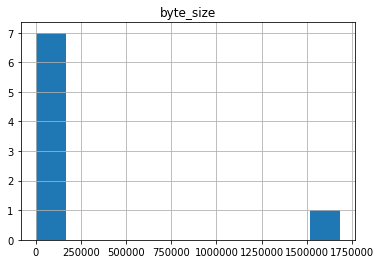

In [124]:
district_data_stats.describe().hist()

#### Data Index

Generate a JS file that webpack can use to make paths for all of the data files.

In [125]:
def write_district_data_js():
    data_files = list_district_data(OUTPUT_DISTRICT_PATH)
    
    def make_require(data_file):
        basename = os.path.basename(data_file)
        pathname = os.path.join('.', 'district', basename)
        outward_code = basename.split('.')[0]
        return "  {}: require('{}')".format(outward_code, pathname)

    with open('output/district.js', 'w') as file:
        file.write('// NB: This file is generated automatically. Do not edit.\n')
        file.write('export default {\n')
        requires = [
            make_require(data_file)
            for data_file in sorted(data_files)
        ]
        file.write(',\n'.join(requires))
        file.write('\n}\n')
write_district_data_js()

#### NHS Data

In [126]:
[nhs_staff.shape[0], nhs_hospital_postcodes.shape[0]]

[229, 880]

In [127]:
nhs_hospital_postcodes.groupby('hospital_organisation').organisation.count().max()

1

In [129]:
def write_nhs_staff_data():
    with open('output/nhs_staff.json', 'w') as file:
        file.write(
            nhs_staff.sort_values('organisation', ascending=True).\
            to_json(orient='split', index=False))
write_nhs_staff_data()